# playground: stochastic-geometric 6D pose estimation

### setup of experiment

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve

features = {
    'p1': np.array([0, -25, -43.30]),
    'p2': np.array([100, -25, -43.30]),
    'p3': np.array([0, 61.60, -93.30]),
    'p4': np.array([100, 111.60, -6.70]),
    'p5': np.array([100, 25, 43.30]),
    'p6': np.array([0, 111.60, -6.70]),
}

features_arr = np.row_stack(list(features.values()))

C = 1000
sensors = {
    's1': np.array([C, 0, 0]),
    's2': np.array([0, 0, C]),
    's3': np.array([0, -C, 0])
}

np.set_printoptions(threshold=np.inf)
np.set_printoptions(linewidth=np.inf)

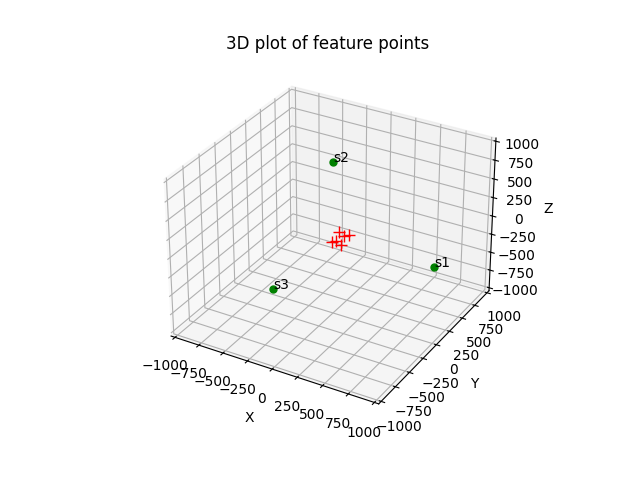

In [2]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot object points
for label, (x,y,z) in features.items():
    ax.plot(x,y,z, "+", markersize=8, label=label, color="r")
    # ax.text(x,y,z, label)

# plot each point and annotate it label
for label, (x,y,z) in sensors.items():
    ax.plot(x,y,z, ".", markersize=10, label=label, color="g")
    ax.text(x,y,z, label)


# plot data points
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D plot of feature points')

ax.set_xlim([-C, C])
ax.set_ylim([-C, C])
ax.set_zlim([-C, C])

plt.show()

### observation function for lateration

In [3]:
from scipy.spatial.transform import Rotation
    
# rigid body transformation x,y,z-axis
def p1_xyz(z, alpha, w):
    R_x = Rotation.from_euler('x', alpha[0])
    R_y = Rotation.from_euler('y', alpha[1])
    R_z = Rotation.from_euler('z', alpha[2])
    return R_z.apply(R_y.apply(R_x.apply(z + w)))

# observational function of multilateration
def p2(z, alpha, w, gamma):
    u = p1_xyz(z, alpha, w)
    return np.linalg.norm(u-gamma)

def angle_between_vectors(v1, v2):
    # normalize the vectors
    v1_norm = v1 / np.linalg.norm(v1)
    v2_norm = v2 / np.linalg.norm(v2)

    # calculate the angle
    dot_product = np.dot(v1_norm, v2_norm)
    angle_rad = np.arccos(dot_product)
    
    return angle_rad

### Forward model (true distances):

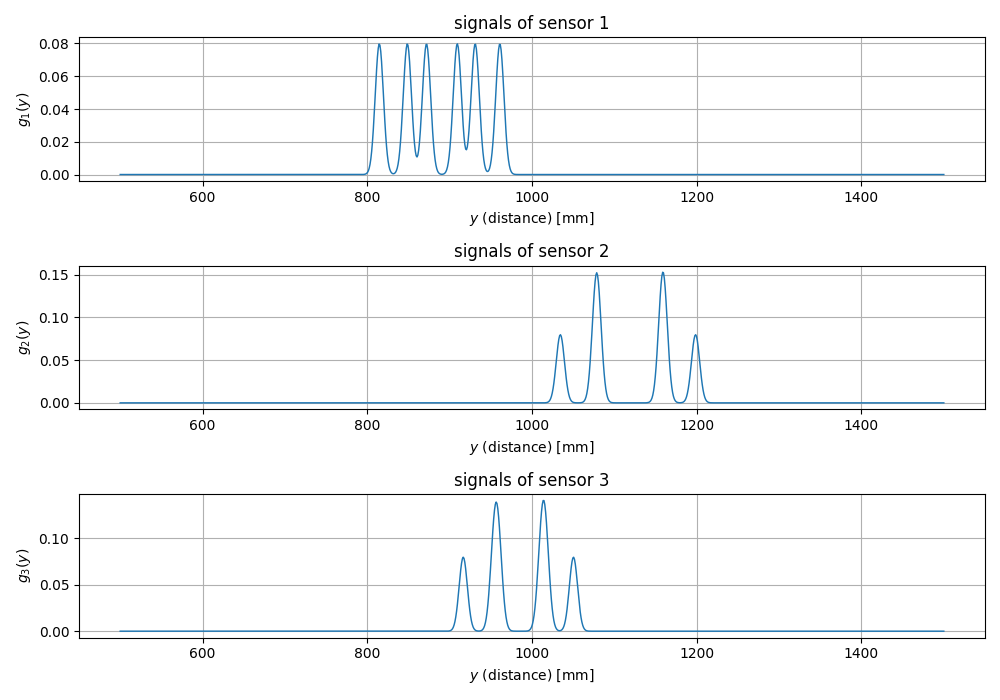

In [13]:
from scipy import interpolate

# set initial location and orientation
# w0 = features_arr.mean(axis=0)
w0 = features['p6']

roll0 = -np.pi/2
pitch0 = angle_between_vectors(np.array([0, 1.0, features['p1'][2]]) - features['p1'], features['p3'] - features['p1'])
yaw0 = 0
V0 = np.array([roll0, pitch0, yaw0])

# V0 = np.ones((3,))*np.pi*(1/3)
# w0 = np.ones((3,))*np.pi*40

# points = np.row_stack(list(features.values()))
# w0 = np.mean(points, axis=0)


# plot sensor data
plt.figure(figsize=(10, 7))

y_pdfs = {}

for i, (slabel, sensor_pos) in enumerate(sensors.items()):

    distances = []
    for flabel, fvec in features.items():
        distances.append(p2(fvec, V0, w0, sensor_pos))

    x = np.linspace(500, 1500, 1000)
    y = np.zeros_like(x)
    sigma = 5
        
    for d in distances:
        # add a gaussian kernel for each distance
        gaussian_norm_const  = 1/(np.sqrt(2*np.pi)*sigma)
        y += gaussian_norm_const  * np.exp(-((x - d)**2) / (2 * sigma**2))


    y_pdfs[slabel] = interpolate.interp1d(x, y)
    
    # add a subplot for the current sensor
    plt.subplot(len(sensors), 1, i+1)
    plt.plot(x, y, linewidth=1.05)
    plt.title(f"signals of sensor {i+1}")
    plt.xlabel(fr'$y$ (distance) [mm]')
    plt.ylabel(fr'$g_{i+1}(y)$')
    plt.grid(True)

plt.tight_layout()
plt.show()


### feature coordinate mixture model

In [5]:
# draw R samples for each feature coordinate

def q(z, std, R):
    z_sampled = np.random.normal(z, std, size=(R, z.shape[0]))
    
    if (z_sampled.shape[0] == 1):
        return z_sampled[0]
    
    return z_sampled

### drawing R measurements from mixture model

In [6]:
# sample measurements for each feature point

sampled_feature_pnts = {}
R = 50
std = 10
for feature_label, feature_coords in features.items():
    sampled_feature_pnts[feature_label] = q(feature_coords, std, R)

sampled_feature_pnts

{'p1': array([[  1.84993372, -23.13445333, -49.31384257],
        [  9.88518796, -25.47517514, -42.75134634],
        [ -6.7202639 , -23.78268697, -47.55056928],
        [ -4.48280042, -15.90494327, -54.09545502],
        [-15.86160685, -10.11737011, -17.93797799],
        [ -1.59569542, -18.12576616, -41.35996586],
        [ -6.80742514, -12.85448623, -39.21512745],
        [ -6.30970705, -19.87631599, -37.43842416],
        [  3.74327999, -33.45053679, -49.08954705],
        [ -4.80386576, -24.80940388, -29.56612358],
        [ 20.06095893, -19.84236692, -53.57184774],
        [ -0.08670079, -14.62625547, -53.87866525],
        [  7.14975834, -28.26381883, -44.98673543],
        [ -2.28683381, -44.10907809, -36.74688677],
        [  4.04243687, -15.98469381, -62.22179977],
        [ 17.50601371, -17.5439357 , -33.44115057],
        [-15.22003961, -36.1490711 , -51.40200291],
        [-13.41930815, -24.9214823 , -59.7109941 ],
        [-17.59560709, -28.97200181, -23.48509763],
      

In [7]:
# calculate distances from observation functions p1,p2 and interpolate from pdf of  mixture model

distances = {l : [] for l in sensors.keys()}
y_pdf = {l : [] for l in sensors.keys()}

cost_sum = 0
for N, (feature_label, samples_arr) in enumerate(sampled_feature_pnts.items()):
    for R, zi_vec, in enumerate(samples_arr):
        inner_product = 1
        for sensor_label, sensor_coords in sensors.items():
            d = p2(zi_vec, V0, w0, sensor_coords)
            distances[sensor_label].append(d)
            y_pdf[sensor_label].append(y_pdfs[sensor_label](d))
            inner_product *= y_pdf[sensor_label][-1]
            
        cost_sum += inner_product
            
cost_sum
# y_pdf

0.03623900609432436

In [8]:
N = len(sampled_feature_pnts)
R = len(sampled_feature_pnts['p1'])

# cost function
def f_cost(x0, *args):
    V, w = x0.reshape(2,3)
    
    cost_sum = 0.0
    for _, samples_arr in sampled_feature_pnts.items():
        for z_vec in samples_arr:
            inner_product = 1.0
            for sensor_label, sensor_coords in sensors.items():
                inner_product *= y_pdfs[sensor_label](p2(z_vec, V, w, sensor_coords))
                
            cost_sum += inner_product
    
    return cost_sum / (N*R)

(N, R)

(6, 50)

In [9]:
from scipy.optimize import minimize

true_pose = np.concatenate((V0, w0))

w_guess = q(w0, 10, 1)
V_guess = q(V0, 0.4, 1)

x0 = np.concatenate((V_guess, w_guess))
alpha_opt = minimize(f_cost, x0, method='Nelder-Mead', tol=10e-9)
alpha_opt.x

print("%s"%str(true_pose))  # real pose
print(x0)                   # perturbed pose
print(alpha_opt.x)          # predicted pose
a, b = x0.reshape(2,3)


[ -1.57079633   0.52361148   0.           0.         111.6         -6.7       ]
[ -1.49637462   0.7397458    0.18299459  -2.47449798 120.93470308 -30.68910376]
[ -1.4171395    0.59347117   0.15598219  -2.23030286 130.8499763  -55.02804051]


In [10]:
# # test plot of cost function

# # k=0

# for k in range(3):

#     # define ranges for V0 and w0
#     Vk_range = np.linspace(-2.5, 2.5, 50)
#     wk_range = np.linspace(-50, 150, 50)

#     # initialize cost surface
#     cost_surface = np.zeros((len(Vk_range), len(wk_range)))

#     # calculate the cost for each combination of V0 and w0
#     for i, Vk_ in enumerate(Vk_range):
#         for j, wk_ in enumerate(wk_range):
#             V, w = V0.copy(), w0.copy()
#             V[k], w[k] = Vk_, wk_
            
#             x0 = np.concatenate((V, w))
#             cost_surface[i, j] = f_cost(x0)

#     from scipy.interpolate import interp2d
#     interp_func = interp2d(Vk_range, wk_range, cost_surface.T, kind='cubic')
#     alpha_opt_z = interp_func(alpha_opt.x[:3][k], alpha_opt.x[3:][k])[0]
#     true_pose_z = interp_func(true_pose[:3][k], true_pose[3:][k])[0]

#     # plotting the cost surface
#     V_mesh, w_mesh = np.meshgrid(Vk_range, wk_range)

#     fig = plt.figure()
#     ax = fig.add_subplot(111, projection='3d')

#     # ax.scatter(alpha_opt.x[:3][1], alpha_opt.x[3:][1], alpha_opt_z, color='red', s=100, marker='x')
#     # ax.scatter(true_pose[:3][1], true_pose[3:][1], true_pose_z, color='green', s=100, marker='x')
#     ax.plot(alpha_opt.x[:3][k], alpha_opt.x[3:][k], alpha_opt_z, color='red', marker='x', markersize=10, zorder=100)
#     ax.plot(true_pose[:3][k], true_pose[3:][k], true_pose_z, color='magenta', marker='x', markersize=10, zorder=100)

#     ax.plot_surface(V_mesh, w_mesh, cost_surface.T, cmap='viridis')

#     ax.set_xlabel('V')
#     ax.set_ylabel('w')
#     ax.set_zlabel('Cost Sum')
#     plt.title('Cost Function')

#     plt.show()

/tmp/ipykernel_25578/1449763357.py:25: DeprecationWarning: `interp2d` is deprecated!
`interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interp_func = interp2d(Vk_range, wk_range, cost_surface.T, kind='cubic')
/tmp/ipykernel_25578/1449763357.py:26: DeprecationWarning:         `interp2d` is deprecated!
        `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.13.0.

        For legacy code, nearly bug-for-bug compatible replacements are
        `RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
        scattered 2D data.

      

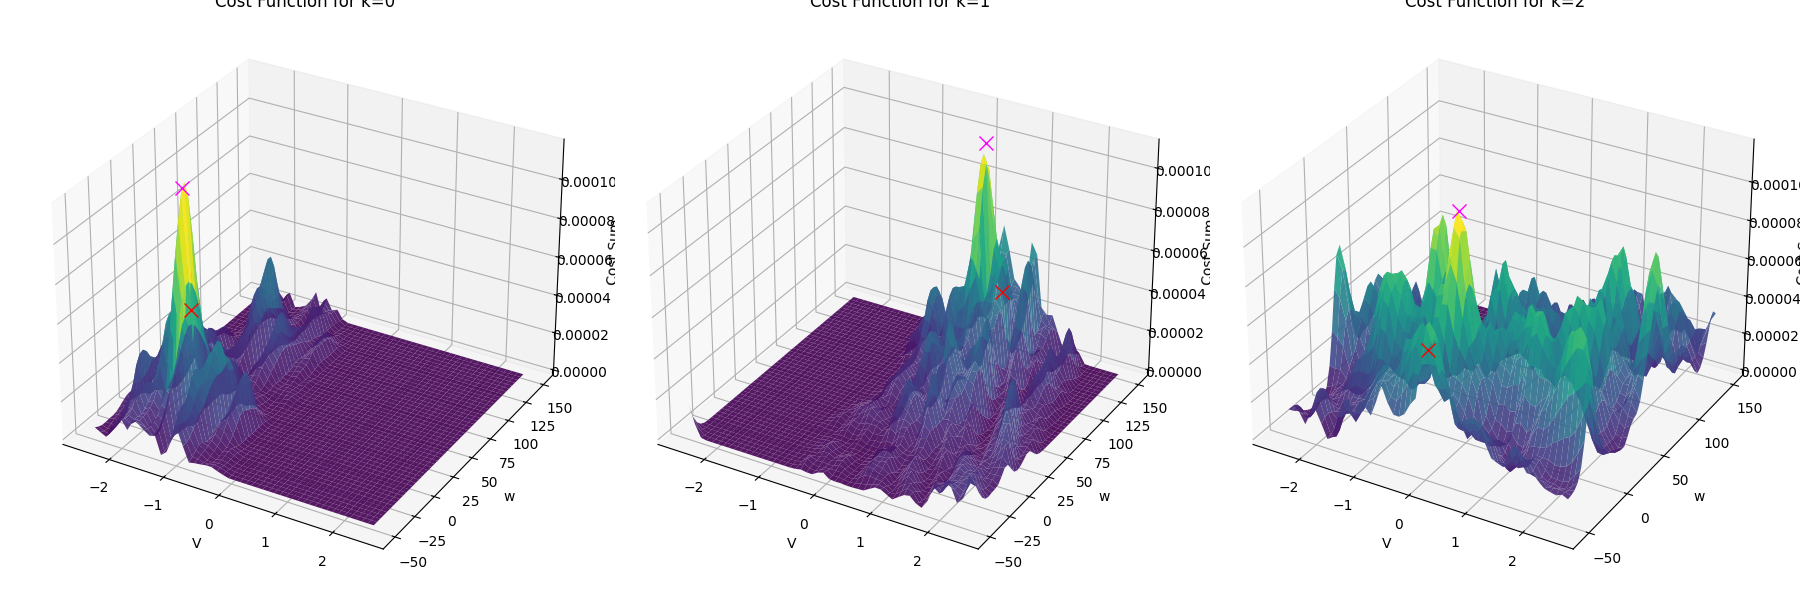

In [11]:
from scipy.interpolate import interp2d

# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, subplot_kw={'projection': '3d'}, figsize=(18, 6))

# Loop over k
for k in [0,1,2]:
    # define ranges for V0 and w0
    Vk_range = np.linspace(-2.5, 2.5, 50)
    wk_range = np.linspace(-50, 150, 50)

    # initialize cost surface
    cost_surface = np.zeros((len(Vk_range), len(wk_range)))

    # calculate the cost for each combination of V0 and w0
    for i, Vk_ in enumerate(Vk_range):
        for j, wk_ in enumerate(wk_range):
            V, w = V0.copy(), w0.copy()
            V[k], w[k] = Vk_, wk_

            x0 = np.concatenate((V, w))
            cost_surface[i, j] = f_cost(x0)

    # Interpolation for alpha_opt and true_pose
    interp_func = interp2d(Vk_range, wk_range, cost_surface.T, kind='cubic')
    alpha_opt_z = interp_func(alpha_opt.x[:3][k], alpha_opt.x[3:][k])[0]
    true_pose_z = interp_func(true_pose[:3][k], true_pose[3:][k])[0]

    # Generate meshgrid for plotting
    V_mesh, w_mesh = np.meshgrid(Vk_range, wk_range)

    # Plotting the cost surface
    axes[k].plot_surface(V_mesh, w_mesh, cost_surface.T, cmap='viridis', alpha=0.9)

    # Plot the optimal and true points
    axes[k].plot(alpha_opt.x[:3][k], alpha_opt.x[3:][k], alpha_opt_z, color='red', marker='x', markersize=10, zorder=100)
    axes[k].plot(true_pose[:3][k], true_pose[3:][k], true_pose_z, color='magenta', marker='x', markersize=10, zorder=100)

    # Set labels and title for each subplot
    axes[k].set_xlabel('V')
    axes[k].set_ylabel('w')
    axes[k].set_zlabel('Cost Sum')
    axes[k].set_title(f'Cost Function for k={k}')

# Show plot
plt.tight_layout()
plt.show()